In [1]:
import sys
sys.path.append("/n/home12/binxuwang/Github/Neuro-ActMax-GAN-comparison")
import torch
import numpy as np
import os
from os.path import join
from tqdm import tqdm, trange
from PIL import Image
import pickle as pkl
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
from core.utils.dataset_utils import ImagePathDataset, normalizer, denormalizer
from torchvision import transforms
from neuro_data_analysis.neural_data_lib import load_img_resp_pairs_multiwindow, load_neural_data # load_img_resp_pairs_multiwindow
# from CorrFeatTsr_lib import Corr_Feat_Machine, visualize_cctsr, loadimg_preprocess
# from core.utils.layer_hook_utils import featureFetcher_module
# from core.utils.CNN_scorers import TorchScorer, load_featnet
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [2]:
import platform
if platform.system() == "Windows":
    stim_rootdir = "S:"
    device = "cuda"
elif platform.system() == "Darwin":
    stim_rootdir = "/Users/binxuwang/Network_mapping"
    device = "mps"
elif platform.system() == "Linux":
    stim_rootdir = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Datasets"
    device = "cuda"

# load the neural data
BFEStats_merge, BFEStats = load_neural_data()

In [3]:
rsp_wdws = [range(50, 200), range(0, 50), range(50, 100), range(100, 150), range(150, 200)]


In [5]:

embed_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')

Using cache found in /n/holylabs/LABS/kempner_fellows/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main
/n/holylabs/LABS/kempner_fellows/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/n/holylabs/LABS/kempner_fellows/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/n/holylabs/LABS/kempner_fellows/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [ ]:
# Define the response time windows
# rsp_wdws += [range(strt, strt+25) for strt in range(0, 200, 25)]
# get image sequence and response in different time windows
# image paths: (n_images, )
# response: (n_images, n_time)
Expi = 155
Expi = 165
imgfps0, resp_mat0, gen_vec0 = load_img_resp_pairs_multiwindow(BFEStats, Expi,
                         "Evol", thread=0, stimdrive=stim_rootdir,
                        output_fmt="vec", rsp_wdws=rsp_wdws)
imgfps1, resp_mat1, gen_vec1 = load_img_resp_pairs_multiwindow(BFEStats, Expi,
                         "Evol", thread=1, stimdrive=stim_rootdir,
                         output_fmt="vec", rsp_wdws=rsp_wdws)

In [ ]:
embed_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')


In [ ]:
def embed_imgs(imgfps, embed_model, batch_size=100, size=224, device="cuda"):
    dataset = ImagePathDataset(imgfps, transform=transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        normalizer,
    ]))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    embed_model = embed_model.to(device)
    embed_model.eval()
    embeddings = []
    for batch, _ in tqdm(dataloader):
        with torch.no_grad():
            embed_vec = embed_model(batch.to(device))
        embeddings.append(embed_vec)
    embeddings = torch.cat(embeddings, dim=0).detach().cpu()
    return embeddings, dataset

In [ ]:

embeddings0, dataset0 = embed_imgs(imgfps0, embed_model, batch_size=100, size=224, device=device)
embeddings1, dataset1 = embed_imgs(imgfps1, embed_model, batch_size=100, size=224, device=device)

In [ ]:
BFEStats[1]["meta"]

In [8]:
embed_root = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/BigGAN_img_embedding"
embed_dir = join(embed_root, "dinov2_vitb14")
os.makedirs(embed_dir, exist_ok=True)

In [ ]:

for Expi in trange(63, 1 + 190):
    if BFEStats[Expi-1]["evol"] is None:
        print(f"Exp {Expi} is None")
        continue
    try:
        imgfps0, resp_mat0, gen_vec0 = load_img_resp_pairs_multiwindow(BFEStats, Expi,
                            "Evol", thread=0, stimdrive=stim_rootdir,
                            output_fmt="vec", rsp_wdws=rsp_wdws)
        imgfps1, resp_mat1, gen_vec1 = load_img_resp_pairs_multiwindow(BFEStats, Expi,
                            "Evol", thread=1, stimdrive=stim_rootdir,
                            output_fmt="vec", rsp_wdws=rsp_wdws)
    except IndexError or FileNotFoundError:
        print(f"File missing for Exp {Expi}")
        continue
    if len(imgfps0) == 0 or len(imgfps1) == 0:
        continue
    embeddings0, dataset0 = embed_imgs(imgfps0, embed_model, batch_size=100, size=224, device=device)
    embeddings1, dataset1 = embed_imgs(imgfps1, embed_model, batch_size=100, size=224, device=device)
    embed_act_dict = {
        "embeddings0": embeddings0,
        "embeddings1": embeddings1,
        "imgfps0": imgfps0,
        "imgfps1": imgfps1,
        "resp_mat0": resp_mat0,
        "resp_mat1": resp_mat1,
        "gen_vec0": gen_vec0,
        "gen_vec1": gen_vec1,
    }
    pkl.dump(embed_act_dict, open(join(embed_dir, f"Exp{Expi:03d}_embed_act_data.pkl"), "wb"))
    print(f"Exp {Expi} done. saved to {embed_dir}")


In [ ]:
from core.utils.dataset_utils import create_imagenet_valid_dataset
rootdir = r"/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Datasets/imagenet-valid"
INdataset = create_imagenet_valid_dataset(imgpix=224,rootdir=rootdir)

In [ ]:
# show the image
img, score = INdataset[1]
plt.imshow(denormalizer(img).permute(1, 2, 0))
plt.title(score)

In [ ]:
dataloaders = DataLoader(INdataset, batch_size=256, shuffle=False, num_workers=8)

In [ ]:
embed_model.cuda().eval()
embedding_col = []
for batch, _ in tqdm(dataloaders):
    with torch.no_grad():
        embed_vec = embed_model(batch.cuda())
    embedding_col.append(embed_vec.detach().cpu())

embedding_mat = torch.cat(embedding_col, dim=0)

In [ ]:
dataset = ImagePathDataset(imgfps0, transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalizer,
]))
dataloader = DataLoader(dataset, batch_size=100, shuffle=False, num_workers=0)


In [ ]:
embed_model = embed_model.cuda()
embed_model.eval()
embeddings = []
for batch, _ in tqdm(dataloader):
    batch = batch.cuda()
    with torch.no_grad():
        embed_vec = embed_model(batch)
    embeddings.append(embed_vec)
embeddings = torch.cat(embeddings, dim=0)



In [10]:
IN_emb = pkl.load(open(join(embed_dir, "imagenet_valid_embedding.pkl"), "rb"))

In [29]:
IN_mean = IN_emb.mean(dim=0)
IN_covmat = torch.cov(IN_emb.T)
# eigh decomposition
IN_eigval, IN_eigvec = torch.linalg.eigh(IN_covmat.cuda(), )
IN_eigval = torch.flip(IN_eigval, dims=[0]).cpu()
IN_eigvec = torch.flip(IN_eigvec, dims=[1]).cpu()

In [38]:
IN_precmat = torch.pinverse(IN_covmat.cuda(),rcond=1e-5).cpu()

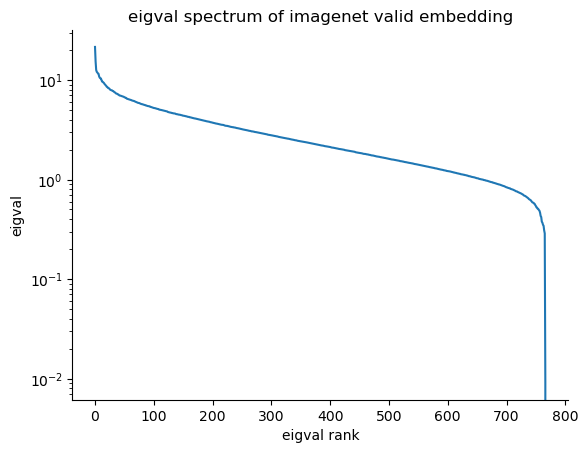

In [ ]:
plt.semilogy(IN_eigval.cpu().numpy())
plt.xlabel("eigval rank")
plt.ylabel("eigval")
plt.title("eigval spectrum of imagenet valid embedding")
plt.show()

In [40]:
# compute mahalanobis distance
def mahalanobis_sqdist(x, mean, eigvec, eigval, eigfloor=1e-5):
    x = x - mean[None, :]
    # rotate
    rot_x = x @ eigvec
    # scale
    return (rot_x ** 2 / torch.clamp(eigval[None, :], min=eigfloor)).sum(dim=1)

In [118]:
Expi = 181
Evol_data = pkl.load(open(join(embed_dir, f"Exp{Expi}_embed_act_data.pkl"), "rb"))
embeddings0 = Evol_data["embeddings0"]
embeddings1 = Evol_data["embeddings1"]
imgfps0 = Evol_data["imgfps0"]
imgfps1 = Evol_data["imgfps1"]
resp_mat0 = Evol_data["resp_mat0"]
resp_mat1 = Evol_data["resp_mat1"]
gen_vec0 = Evol_data["gen_vec0"]
gen_vec1 = Evol_data["gen_vec1"]

In [119]:
MHdist_0 = mahalanobis_sqdist(embeddings0, IN_mean, IN_eigvec, IN_eigval, eigfloor=1e-2)
MHdist_1 = mahalanobis_sqdist(embeddings1, IN_mean, IN_eigvec, IN_eigval, eigfloor=1e-2)

In [120]:
# t test on the mahalanobis distance for gen 1 and last gen 
from scipy.stats import ttest_ind
print(ttest_ind(MHdist_0[gen_vec0<=3], MHdist_0[gen_vec0>=gen_vec0.max()-2]))
print(ttest_ind(MHdist_1[gen_vec1<=2], MHdist_1[gen_vec1>=gen_vec1.max()-1]))

TtestResult(statistic=10.659300886452305, pvalue=9.240812417506662e-21, df=175.0)
TtestResult(statistic=-2.003101755343388, pvalue=0.04787257686811909, df=100.0)


In [121]:
def compute_mean_var(x, gen_vec, var="std"):
    meanvec = []
    errvec = []
    for gen in range(gen_vec.min(), gen_vec.max()+1):
        meanvec.append(x[gen_vec==gen].mean())
        if var == "std":
            errvec.append(x[gen_vec==gen].std())
        elif var == "var":
            errvec.append(x[gen_vec==gen].var())
        elif var == "sem":
            errvec.append(x[gen_vec==gen].std() / np.sqrt((gen_vec==gen).sum()))
    return torch.tensor(meanvec), torch.tensor(errvec)

def plot_shaded_errorbar(x, y, color="b", label="", var="std", **kwargs):
    meanvec, errvec = compute_mean_var(y, x, var=var)
    plt.plot(np.unique(x), meanvec, color=color, label=label, **kwargs)
    plt.fill_between(np.unique(x), meanvec-errvec, meanvec+errvec, color=color, alpha=0.3)

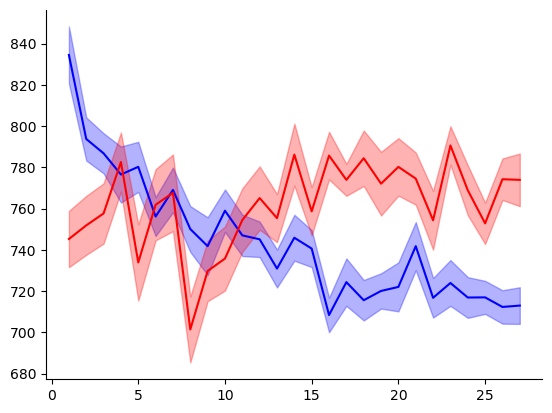

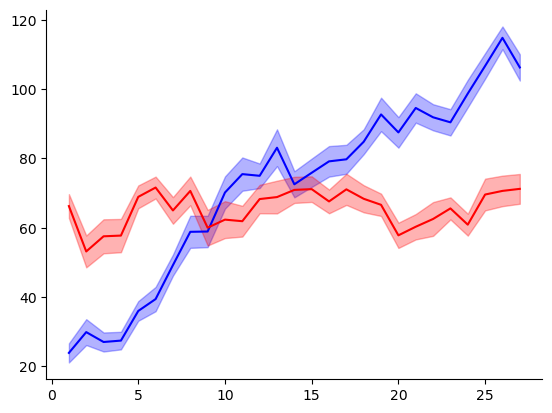

In [122]:
plt.figure()
plot_shaded_errorbar(gen_vec0, MHdist_0, color="b", label="thread 0", var="sem")
plot_shaded_errorbar(gen_vec1, MHdist_1, color="r", label="thread 1", var="sem")
plt.show()

plt.figure()
plot_shaded_errorbar(gen_vec0, resp_mat0[:, 0], color="b", label="thread 0", var="sem")
plot_shaded_errorbar(gen_vec1, resp_mat1[:, 0], color="r", label="thread 1", var="sem")
plt.show()

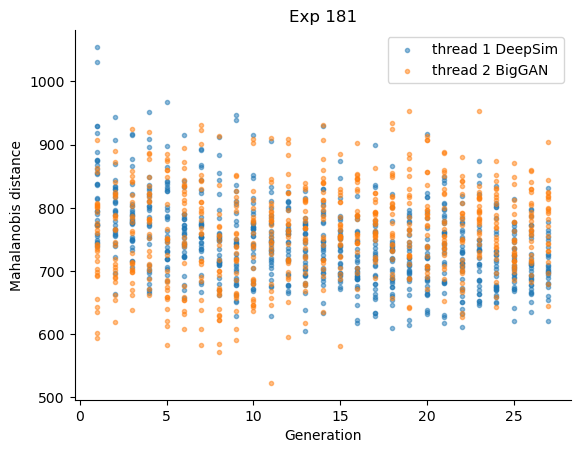

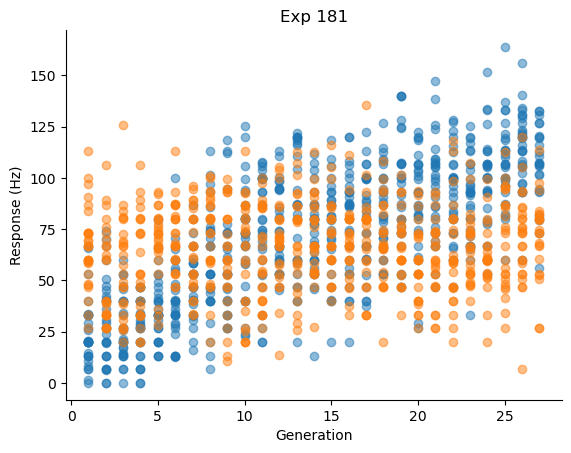

In [123]:
plt.scatter(gen_vec0, MHdist_0, label="thread 1 DeepSim", marker=".", alpha=0.5)
plt.scatter(gen_vec1, MHdist_1, label="thread 2 BigGAN", marker=".", alpha=0.5)
plt.legend()
plt.xlabel("Generation")
plt.ylabel("Mahalanobis distance")
plt.title(f"Exp {Expi}")
plt.show()

plt.plot(gen_vec0[:,],resp_mat0[:, 0], "o", alpha=0.5)
plt.plot(gen_vec1[:,],resp_mat1[:, 0], "o", alpha=0.5)
plt.xlabel("Generation")
plt.ylabel("Response (Hz)")
plt.title(f"Exp {Expi}")
plt.show()

In [22]:
embeddings1.shape

torch.Size([580, 768])

In [21]:
embeddings0.shape

torch.Size([910, 768])